# QAL-BP: An Augmented Lagrangian Quantum Approach for Bin Packing

This notebook demonstrates the pipeline of solving the Bin Packing problem using QAL-BP.

Consider that when using Quantum Annealing results may stongly vary from one run to another, influencing also the benchmark analysis.

**IMPORTANT: before running this notebook create a config.py file with the variable dimod.token="your_token" in the same folder of the notebook**

In [1]:
!git clone https://github.com/Lorenz92/QAL-BP.git
%cd QAL-BP/
!ls

fatal: destination path 'QAL-BP' already exists and is not an empty directory.
/content/QAL-BP
config.py		    minimum_eigenvals.png  __pycache__	 results      utils.py
feasible_density.png	    num_bins.png	   QAL_BP.ipynb  tts_log.png
gurobi_df_40_instances.csv  num_vars_n.png	   README.md	 tts.png


## Install and Import Dependencies

In [2]:
# If this notebook is running on Windows OS, change apt with tlmgr
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive-fonts-extra is already the newest version (2021.20220204-1).
texlive-fonts-recommended is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [3]:
!pip install gurobipy pyqubo dimod dwave-system SciencePlots

In [4]:
# ! pip install dwave-inspector
# ! pip install dwave-inspectorapp --extra-index=https://pypi.dwavesys.com/simple

In [5]:
import pandas as pd
from utils import *

json_path = './solutions/'
num_reads = 100

%matplotlib inline

%load_ext autoreload
%autoreload 2

# The following parameter decide wether to read past results from file or from newly computed experiments
results_from_file = False

# The following parameter allows to run also the exact solver (this might take a lot of time)
run_exact_solver = False

# The following parameter controls wether to include also the Pseudo Polynomial model in the experiments
solve_PseudoPoly=False

# The Bin Packing Problem

The bin packing problem (BPP) is a classic optimization task that involves packing objects of different sizes into containers, or bins, with a limited capacity.
The goal is to minimize the number of bins needed to pack all the objects.
A mathematical formulation of the bin packing problem can be expressed as follows: given a set of $n$ items of given integer size (or weight) $w_j \ (j = 1, \ldots , n)$ the goal is to pack them
 into the minimum number of identical bins of integer capacity $C$.

Let $m$ be any upper bound on the solution value and let introduce $y_i, x_{ij}$ two sets of binary variables such that:
$y_i (i = 1, \ldots, m)$ takes the value $1$ if and only if bin $i$ is used in the solution
and $x_{ij} (i = 1, \ldots, m; j = 1, \ldots, n)$ takes the value $1$ if and only if item $j$ is packed into bin $i$.
A commonly adopted Integer Linear Programming (ILP) problem formulation is given by *S. Martello and P. Toth, in “Knapsack Problems: Algorithms and Computer Implementation”* and is the following:

\begin{align}
  \underset{x, y}{\operatorname{argmin}} \ & \sum_{i=1}^m y_i \\
  \text{s.t. }
  & \sum_{i=1}^m x_{ij} = 1 & \forall j = 1, \dots, n \\
  & \sum_{j=1}^n w_j x_{ij} \leq C y_i & \forall i = 1, \dots, m \\
  & x_{ij} \in \{0, 1\} & \forall i = 1, \dots, m, \ \forall j = 1, \dots, n  \\
  & y_{i} \in \{0, 1\} & \forall i = 1, \dots, m
\end{align}


## Bin Packing Problem instances generation

In the following experiments we consider a set of 40 instances with number of items ranging from 3 to 10 and a fixed bin capacity of 10. The different instances are randomly generated using 5 different seeds.

In [6]:
# Instances used for QA and SA
seeds = [23, 42, 123, 90, 510]

instances = {
    'bpp_3_10': {
        'num_items' : 3,
        'bin_capacity' : 10,
    },
    'bpp_4_10': {
        'num_items' : 4,
        'bin_capacity' : 10,
    },
    'bpp_5_10': {
        'num_items' : 5,
        'bin_capacity' : 10,
    },
    'bpp_6_10': {
        'num_items' : 6,
        'bin_capacity' : 10,
    },
    'bpp_7_10': {
        'num_items' : 7,
        'bin_capacity' : 10,
    },
    'bpp_8_10': {
        'num_items' : 8,
        'bin_capacity' : 10,
    },
    'bpp_9_10': {
        'num_items' : 9,
        'bin_capacity' : 10,
    },
    'bpp_10_10': {
        'num_items' : 10,
        'bin_capacity' : 10,
    }
}

The following cell is used to generates the parameters $A$ and $B$ of the Pseudo Polynomial model.

In [7]:
As = [.1,.3,.5,1,3,5,10,25,50,100,1000]
Bs = [.01,.05,.1,.5,1,2,5,10]

PP_pens=[]
for a in As:
  for b in Bs:
    pen = {}
    pen['A'] = a
    pen['B'] = b
    PP_pens.append(pen)

print(f'Number of parameters values combination: {len(PP_pens)}')

Number of parameters values combination: 88


Generation of the instances dataframe.

In [8]:
df_seeds = pd.DataFrame()

for seed in seeds:
  df_seed = instance_generator(instances, seed)
  df_seeds = pd.concat([df_seeds, df_seed], axis = 0, ignore_index=True)

df = df_seeds.copy()
df.head()

,instance_name,seed,c,w,n,wmin,wmax,lb
0,bpp_3_10,23,10,"[4, 8, 6]",3,4,8,2
1,bpp_4_10,23,10,"[7, 5, 4, 7]",4,4,7,3
2,bpp_5_10,23,10,"[4, 4, 7, 7, 9]",5,4,9,4
3,bpp_6_10,23,10,"[6, 5, 5, 5, 4, 8]",6,4,8,4
4,bpp_7_10,23,10,"[8, 6, 8, 6, 8, 6, 6]",7,6,8,5


# ILP Formulation of BPP solved via Branch-and-Bound by Gurobi

In this section, we solve the ILP formulation given above via the Gurobi optimizer, as a representative for state-of-the-art solution that relies on the branch-and-bound technique to efficiently find the optimal solution.

In [9]:
gurobi_df = gurobi_solve(df, num_reads)
gurobi_df.to_csv('./gurobi_df_40_instances.csv',float_format='%.6f')

df_total = pd.concat([df, gurobi_df], axis = 1)
display(df_total)

Restricted license - for non-production use only - expires 2024-10-28


,instance_name,seed,c,w,n,wmin,wmax,lb,gurobi_n_bins,gurobi_bin_for_item,gurobi_runtime,bin_filling
0,bpp_3_10,23,10,"[4, 8, 6]",3,4,8,2,2.0,"[2, 0, 2]",457.85,"{2: 10, 0: 8}"
1,bpp_4_10,23,10,"[7, 5, 4, 7]",4,4,7,3,3.0,"[1, 3, 3, 2]",716.55,"{1: 7, 3: 9, 2: 7}"
2,bpp_5_10,23,10,"[4, 4, 7, 7, 9]",5,4,9,4,4.0,"[0, 0, 4, 2, 1]",964.97,"{0: 8, 4: 7, 2: 7, 1: 9}"
3,bpp_6_10,23,10,"[6, 5, 5, 5, 4, 8]",6,4,8,4,4.0,"[2, 4, 4, 1, 1, 0]",1207.37,"{2: 6, 4: 10, 1: 9, 0: 8}"
4,bpp_7_10,23,10,"[8, 6, 8, 6, 8, 6, 6]",7,6,8,5,7.0,"[0, 2, 6, 4, 3, 5, 1]",655.68,"{0: 8, 2: 6, 6: 8, 4: 6, 3: 8, 5: 6, 1: 6}"
5,bpp_8_10,23,10,"[4, 5, 6, 4, 5, 4, 6, 4]",8,4,6,4,4.0,"[0, 1, 0, 2, 1, 2, 6, 6]",3319.63,"{0: 10, 1: 10, 2: 8, 6: 10}"
6,bpp_9_10,23,10,"[7, 5, 8, 4, 7, 4, 8, 5, 4]",9,4,8,6,7.0,"[2, 7, 6, 1, 5, 1, 0, 8, 8]",1221.76,"{2: 7, 7: 5, 6: 8, 1: 8, 5: 7, 0: 8, 8: 9}"
7,bpp_10_10,23,10,"[5, 7, 5, 7, 9, 9, 4, 9, 6, 4]",10,4,9,7,8.0,"[5, 0, 8, 7, 6, 9, 8, 2, 4, 4]",6244.29,"{5: 5, 0: 7, 8: 9, 7: 7, 6: 9, 9: 9, 2: 9, 4: 10}"
8,bpp_3_10,42,10,"[4, 8, 7]",3,4,8,2,3.0,"[2, 0, 1]",2231.55,"{2: 4, 0: 8, 1: 7}"
9,bpp_4_10,42,10,"[6, 6, 9, 4]",4,4,9,3,3.0,"[2, 0, 1, 0]",4142.65,"{2: 6, 0: 10, 1: 9}"


# Pseudo Polynomial Formulation

The first QUBO formulation of the Bin Packing Problem appeared in *Mapping NP-hard and NP-complete optimisation problems to
Quadratic Unconstrained Binary Optimisation problems, by Bas Lodewijks* in 2019. In this publication, the author a QUBO formulation for the bin acking problem, such as the following:

given the variables $x_{ij}, i \in \{1, .., N\}, j \in \{1, .., K\}$, where $x_{ij} = 1$ if weight $j$ is placed in bin $i$, variables $y_i, i \in \{1, .., N\}$, where $y_i = 1$ if bin $i$ is not empty,
and variables $z_{ik}, i \in \{1, .., N\}, k \in \{1, .., C\}$, where $z_{ik} = 1$ if bin $i$ has been filled up to level $k$, that is, when the sum of the weights of the objects in bin $i$ equals exactly $k$.
The Hamiltonian can be written as:
\begin{align}
    H_A = & A\sum_{i=1}^{N} \left( x_i - \sum_{k=1}^C z_{ik} \right)^2 \\
    + & A\sum_{j=1}^{K} \left( 1 - \sum_{i=1}^N x_{ij} \right)^2 \\
    + & A\sum_{i=1}^{N} \left( \sum_{k=1}^{C}kz_{ik} - \sum_{j=1}^K w_j x_{ij} \right)^2 \\
    + & A\sum_{i=1}^{N} \left( 1 - x_i \right) \sum_{j=1}^K x_{ij} \\
    H_B = & B\sum_{i=1}^N x_{i}
\end{align}

## Pseudo Polynomial model solved by Simulated Annealing

In the next cell we solve the QUBO formulation given by Lodewijks using SA.

In [10]:
if solve_PseudoPoly:
  models = ['PP']
  solvers = ['SA']

  pp_penalties = None
  al_penalties= None
  QUBOs_df = pd.DataFrame()
  PP_test_pens = copy.deepcopy(PP_pens)


  for i in tqdm(range(len(PP_test_pens))):
    pp_penalties = PP_test_pens[i]
    QUBO_df = solve_QUBOs(df, models, solvers, num_reads, al_penalties, pp_penalties, al_gamma_term=True, save_to_json=False, path=json_path)
    QUBOs_df = pd.concat([QUBOs_df, QUBO_df], axis = 0)

  QUBOs_df.head()

  QUBOs_df.to_csv('./final_PP_grid.csv',float_format='%.6f')


# Aumented Lagrangian QUBO Formulation

In this work, we presented QAL-BP (*Quantum Augmented Lagrangian method for Bin Packing*), a novel QUBO formulation for the BPP based on the Augmented Lagrangian method.

The Quantum Augmented Lagrangian method for Bin Packing (QAL-BP) embeds the constraints using the augmented Lagrangian method as follows:
\begin{align}
    \text{argmin}_{x, y} \ & \delta\sum_{i=1}^m y_i \\
    & + \sum_{i=1}^{m} \lambda_i \left( \sum_{j=1}^n w_j x_{ij} - c_i y_i \right) \\
    & + \sum_{i=1}^{m} \rho_i \left( \sum_{j=1}^n w_j x_{ij} - c_i y_i \right)^2 \\
    & + \theta \sum_{j=1}^n \left(\sum_{i=1}^m x_{ij}-1\right)^2 \\
    & +  \gamma \sum_{i=1}^m \left(1 - y_i \right)\sum_{j=1}^n x_{ij} \\
    \text{s.t. }
    x_{ij}& \in \{0, 1\} \qquad \forall i = 1 \dots, m, \forall j = 1 \dots, n \nonumber \\ \nonumber
    y_{i} & \in \{0, 1\} \qquad \forall i = 1 \dots, m \\
    \delta, &\lambda, \rho, \theta, \gamma \ge 0 \nonumber
\end{align}

QUBO penalties are estimated according to **QAL-BP: An Augmented Lagrangian Quantum Approach for Bin Packing Problem** by *Lorenzo Cellini, Antonio Macaluso, and Michele Lombardi*.

In the next two cells the QAL-BP is solved respectively by *Simulated Annealing (SA)* and *Quantum Annealing (QA)*.

### QAL-BP solved by Simulated Annealing

In [11]:
models = ['AL']
solvers = ['SA']

pp_penalties = None
al_penalties = None

df_final_SA = df_total.copy()
QUBO_df = solve_QUBOs(df, models, solvers, num_reads, al_penalties, pp_penalties, al_gamma_term=True, save_to_json=False, path=json_path)
df_final_SA = pd.concat([df_final_SA, QUBO_df], axis = 1)

df_final_SA.to_csv(f'./SA_nr{num_reads}.csv',float_format='%.6f')
df_final_SA.head()

Set penalty as: Default for AL and Default for PP


,instance_name,seed,c,w,n,wmin,wmax,lb,gurobi_n_bins,gurobi_bin_for_item,...,AL_SA_real_weights_sum,AL_SA_placed_weights_sum,AL_SA_used_items,AL_SA_feasible,AL_SA_reason,AL_SA_penalties_dict_delta,AL_SA_penalties_dict_theta,AL_SA_penalties_dict_lmbd,AL_SA_penalties_dict_rho,AL_SA_penalties_dict_gamma
0,bpp_3_10,23,10,"[4, 8, 6]",3,4,8,2,2.0,"[2, 0, 2]",...,18,18,"[0, 2, 1]",True,[],0.15,2,0.1389,0.0278,1
1,bpp_4_10,23,10,"[7, 5, 4, 7]",4,4,7,3,3.0,"[1, 3, 3, 2]",...,23,23,"[3, 0, 1, 2]",True,[],0.15,2,0.1389,0.0278,1
2,bpp_5_10,23,10,"[4, 4, 7, 7, 9]",5,4,9,4,4.0,"[0, 0, 4, 2, 1]",...,31,31,"[0, 1, 3, 2, 4]",True,[],0.15,2,0.1389,0.0278,1
3,bpp_6_10,23,10,"[6, 5, 5, 5, 4, 8]",6,4,8,4,4.0,"[2, 4, 4, 1, 1, 0]",...,33,33,"[5, 1, 3, 0, 2, 4]",True,[],0.15,2,0.1389,0.0278,1
4,bpp_7_10,23,10,"[8, 6, 8, 6, 8, 6, 6]",7,6,8,5,7.0,"[0, 2, 6, 4, 3, 5, 1]",...,48,48,"[1, 5, 0, 2, 3, 6, 4]",True,[],0.15,2,0.0758,0.0152,1


### QAL-BP solved by Quantum Annealing

In [15]:
models = ['AL']
solvers = ['QA']

pp_penalties = None
al_penalties = None

df_final_QA = df_total.copy()
QUBO_df = solve_QUBOs(df, models, solvers, num_reads, al_penalties, pp_penalties, al_gamma_term=True, save_to_json=True, path=json_path)
df_final_QA = pd.concat([df_final_QA, QUBO_df], axis = 1)

df_final_QA.to_csv(f'./QA_nr{num_reads}.csv',float_format='%.6f')
df_final_QA.head()

Set penalty as: Default for AL and Default for PP


,instance_name,seed,c,w,n,wmin,wmax,lb,gurobi_n_bins,gurobi_bin_for_item,...,AL_QA_runtime_metrics_qpu_readout_time_per_sample,AL_QA_runtime_metrics_qpu_access_time,AL_QA_runtime_metrics_qpu_access_overhead_time,AL_QA_runtime_metrics_qpu_programming_time,AL_QA_runtime_metrics_qpu_delay_time_per_sample,AL_QA_runtime_metrics_total_post_processing_time,AL_QA_runtime_metrics_post_processing_overhead_time,AL_QA_cbf,AL_QA_logiqu,AL_QA_physiqu
0,bpp_3_10,23,10,"[4, 8, 6]",3,4,8,2,2.0,"[2, 0, 2]",...,85.64,28376.77,1268.23,15758.77,20.54,126.0,126.0,0.000000,12,16
1,bpp_4_10,23,10,"[7, 5, 4, 7]",4,4,7,3,3.0,"[1, 3, 3, 2]",...,132.80,33093.17,2028.83,15759.17,20.54,694.0,694.0,0.000000,20,35
2,bpp_5_10,23,10,"[4, 4, 7, 7, 9]",5,4,9,4,4.0,"[0, 0, 4, 2, 1]",...,91.78,28991.17,1342.83,15759.17,20.54,1414.0,1414.0,0.000000,30,74
3,bpp_6_10,23,10,"[6, 5, 5, 5, 4, 8]",6,4,8,4,4.0,"[2, 4, 4, 1, 1, 0]",...,71.54,26966.77,3029.23,15758.77,20.54,276.0,276.0,0.000000,42,143
4,bpp_7_10,23,10,"[8, 6, 8, 6, 8, 6, 6]",7,6,8,5,7.0,"[0, 2, 6, 4, 3, 5, 1]",...,88.14,28627.57,2059.43,15759.57,20.54,211.0,211.0,0.017857,56,228


### QAL-BP solved by enumeration (exact method)

**NOTE: be aware that it may take a lot of time and RAM resources to complete**

Indeed we selected the only two smallest instance classes that is capable to solve in a reasonable amount of time.

In [16]:
if run_exact_solver:
  models = ['AL']
  solvers = ['Ex']

  pp_penalties = None
  al_penalties = None

  df_exact = df[df['instance_name'].isin(['bpp_3_10','bpp_4_10'])]

  df_final_Ex = df_total.copy()
  QUBO_df = solve_QUBOs(df, models, solvers, num_reads, al_penalties, pp_penalties, al_gamma_term=True, save_to_json=False, path=json_path)
  QUBO_df.index = list(df_exact.index)
  df_final_Ex = pd.concat([df_final_Ex, QUBO_df], axis = 1)

  display(df_final_Ex)

  df_final_Ex.to_csv('./final_Ex.csv',float_format='%.6f')

# Model evaluation

In [23]:
# Read the previously saved results
if results_from_file:
  df_final_SA = pd.read_csv(f'./results/AL/SA_nr{num_reads}.csv',index_col=0)
  df_final_QA = pd.read_csv(f'./results/AL/QA_nr{num_reads}.csv',index_col=0)
df_final_Ex = pd.read_csv('./results/AL/final_Ex.csv',index_col=0)

## Solutions

What follows is a comparison of the number of bins in solutions obtained by different solvers.

The graphs compares the number of bins in solutions generated by Gurobi, Simulated Annealing (SA), and
Quantum Annealing (QA) solvers for the given set of instances.

In [18]:
df_final_SA['gurobi_n_bins'] = df_final_SA['gurobi_n_bins'].astype(int)

if results_from_file:
  df_final_SA['AL_SA_n_bins'] = df_final_SA['AL_SA_yi'].apply(lambda x:  len(x.strip("'][").replace("'",'').split(', ')))
  df_final_QA['AL_QA_n_bins'] = df_final_QA['AL_QA_yi'].apply(lambda x:  len(x.strip("'][").replace("'",'').split(', ')))

else:
  df_final_SA['AL_SA_n_bins'] = df_final_SA['AL_SA_yi'].apply(lambda x:  len(x))
  df_final_QA['AL_QA_n_bins'] = df_final_QA['AL_QA_yi'].apply(lambda x:  len(x))


df_num_bins_SA = df_final_SA[['instance_name','seed', 'gurobi_n_bins', 'AL_SA_n_bins']]
df_num_bins_QA = df_final_QA[['instance_name','seed','AL_QA_n_bins']]

df_num_bins = pd.concat([df_num_bins_SA, df_num_bins_QA], axis = 1)
df_num_bins = df_num_bins.loc[:,~df_num_bins.columns.duplicated()]

df_num_bins.head()

,instance_name,seed,gurobi_n_bins,AL_SA_n_bins,AL_QA_n_bins
0,bpp_3_10,23,2,2,2
1,bpp_4_10,23,3,3,3
2,bpp_5_10,23,4,4,4
3,bpp_6_10,23,4,4,5
4,bpp_7_10,23,7,7,6


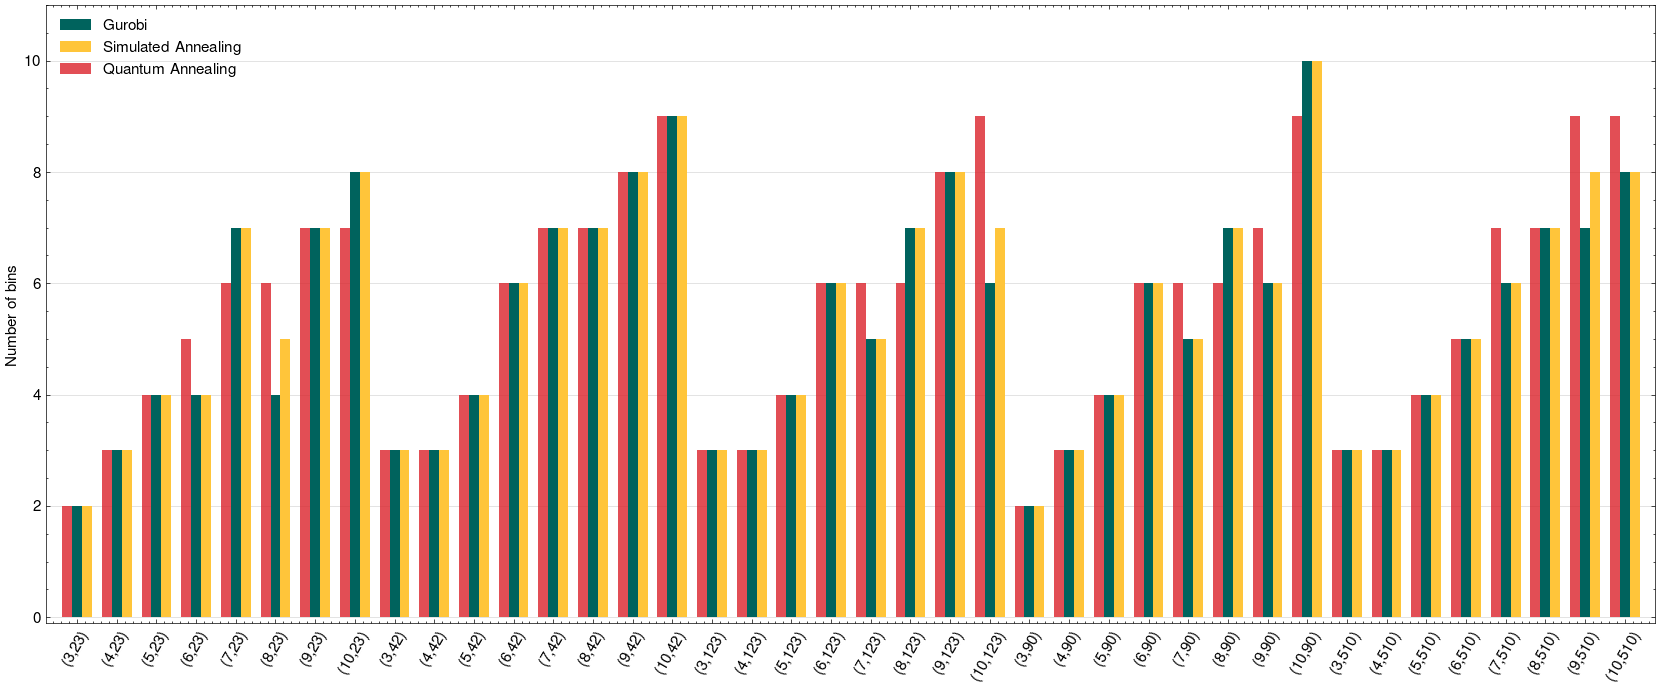

In [19]:
plot_num_bins(df_num_bins)

## Complexity plot

The following cell generate a plot illustrating the model complexity with respect to the number of items and bin capacity.

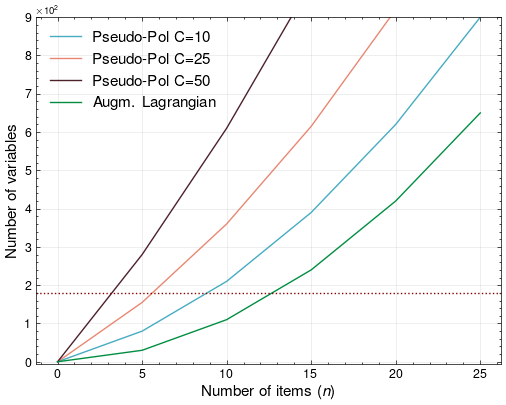

In [20]:
plot_complexity()

## Runtime

The following cells create a plot to illustrate the runtime performance of the QAL-BPP model for various problem instances. It compares the runtime results for different solvers,
including Gurobi, Simulated Annealing (SA) with Augmented Lagrangian (AL) and Quantum Annealing (QA) with Augmented Lagrangian (AL).


In [24]:
df_mean_std_runtime_QA = df_final_QA.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_QA_runtime'].agg(['mean', 'std'])
df_mean_std_runtime_QA.columns = df_mean_std_runtime_QA.columns.map('_'.join)
display(df_mean_std_runtime_QA)

df_mean_std_runtime_SA = df_final_SA.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_SA_runtime'].agg(['mean', 'std'])
df_mean_std_runtime_SA.columns = df_mean_std_runtime_SA.columns.map('_'.join)
display(df_mean_std_runtime_SA)

df_mean_std_runtime_Ex = df_final_Ex.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_Ex_runtime'].agg(['mean', 'std'])
df_mean_std_runtime_Ex.columns = df_mean_std_runtime_Ex.columns.map('_'.join)
display(df_mean_std_runtime_Ex)

df_mean_std_runtime = pd.concat([df_mean_std_runtime_SA, df_mean_std_runtime_QA, df_mean_std_runtime_Ex], axis = 1)
df_mean_std_runtime = df_mean_std_runtime.loc[:,~df_mean_std_runtime.columns.duplicated()].reset_index()
display(df_mean_std_runtime)

<ipython-input-24-04325199534e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mean_std_runtime_QA = df_final_QA.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_QA_runtime'].agg(['mean', 'std'])


,,gurobi_runtime_mean,gurobi_runtime_std,AL_QA_runtime_mean,AL_QA_runtime_std
instance_name,n,,,,
bpp_3_10,3,956.338,757.585914,12148.4,1060.363523
bpp_4_10,4,1509.432,1509.779187,11752.4,3284.803008
bpp_5_10,5,1452.982,1265.257543,12681.6,1511.222948
bpp_6_10,6,1144.258,497.905953,15282.8,4642.613617
bpp_7_10,7,1577.162,1012.593111,17459.6,3846.006604
bpp_8_10,8,3061.324,2944.315445,14588.0,4395.262905
bpp_9_10,9,1629.182,518.390361,17616.4,3349.742199
bpp_10_10,10,3628.106,1623.512173,21682.0,1290.618456


<ipython-input-24-04325199534e>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mean_std_runtime_SA = df_final_SA.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_SA_runtime'].agg(['mean', 'std'])


,,gurobi_runtime_mean,gurobi_runtime_std,AL_SA_runtime_mean,AL_SA_runtime_std
instance_name,n,,,,
bpp_3_10,3,956.338,757.585914,28829.479218,2687.308818
bpp_4_10,4,1509.432,1509.779187,44603.300095,3958.835885
bpp_5_10,5,1452.982,1265.257543,65697.717667,2356.821394
bpp_6_10,6,1144.258,497.905953,90468.454361,3319.011053
bpp_7_10,7,1577.162,1012.593111,118263.912201,3363.848444
bpp_8_10,8,3061.324,2944.315445,156521.224976,8258.969811
bpp_9_10,9,1629.182,518.390361,194236.230850,3060.244969
bpp_10_10,10,3628.106,1623.512173,242597.293854,6442.166127


<ipython-input-24-04325199534e>:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mean_std_runtime_Ex = df_final_Ex.groupby(['instance_name', 'n'], sort=False)['gurobi_runtime','AL_Ex_runtime'].agg(['mean', 'std'])


,,gurobi_runtime_mean,gurobi_runtime_std,AL_Ex_runtime_mean,AL_Ex_runtime_std
instance_name,n,,,,
bpp_3_10,3,524.6,138.575972,1.331339e+04,9541.950851
bpp_4_10,4,773.8,306.236347,2.449602e+06,502457.992174
bpp_5_10,5,868.8,200.092978,1.000000e+13,0.000000
bpp_6_10,6,797.0,239.736313,1.000000e+13,0.000000
bpp_7_10,7,1065.2,219.202418,1.000000e+13,0.000000
bpp_8_10,8,2422.2,1386.158613,1.000000e+13,0.000000
bpp_9_10,9,1759.0,474.914729,1.000000e+13,0.000000
bpp_10_10,10,2618.4,712.045153,1.000000e+13,0.000000


,instance_name,n,gurobi_runtime_mean,gurobi_runtime_std,AL_SA_runtime_mean,AL_SA_runtime_std,AL_QA_runtime_mean,AL_QA_runtime_std,AL_Ex_runtime_mean,AL_Ex_runtime_std
0,bpp_3_10,3,956.338,757.585914,28829.479218,2687.308818,12148.4,1060.363523,1.331339e+04,9541.950851
1,bpp_4_10,4,1509.432,1509.779187,44603.300095,3958.835885,11752.4,3284.803008,2.449602e+06,502457.992174
2,bpp_5_10,5,1452.982,1265.257543,65697.717667,2356.821394,12681.6,1511.222948,1.000000e+13,0.000000
3,bpp_6_10,6,1144.258,497.905953,90468.454361,3319.011053,15282.8,4642.613617,1.000000e+13,0.000000
4,bpp_7_10,7,1577.162,1012.593111,118263.912201,3363.848444,17459.6,3846.006604,1.000000e+13,0.000000
5,bpp_8_10,8,3061.324,2944.315445,156521.224976,8258.969811,14588.0,4395.262905,1.000000e+13,0.000000
6,bpp_9_10,9,1629.182,518.390361,194236.230850,3060.244969,17616.4,3349.742199,1.000000e+13,0.000000
7,bpp_10_10,10,3628.106,1623.512173,242597.293854,6442.166127,21682.0,1290.618456,1.000000e+13,0.000000


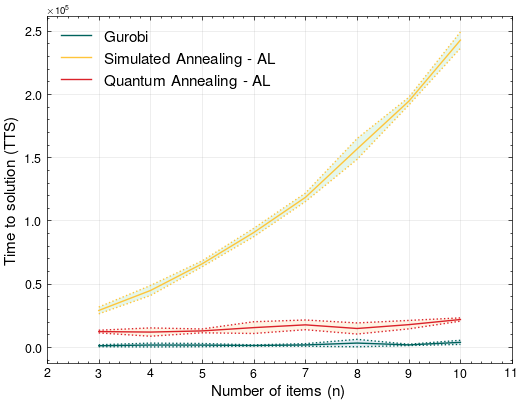

In [25]:
plot_runtime(df_mean_std_runtime)

Plotting the same results in log scale allows to observe also the runtime performance of the exact solver.

/content/QAL-BP/utils.py:1189: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 10 ** 12)


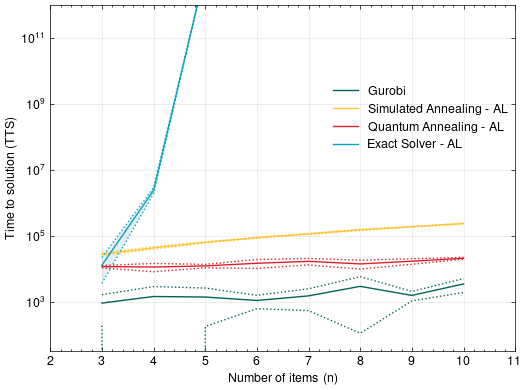

In [26]:
plot_runtime_logscale(df_mean_std_runtime)

## Minimum eigenvalues distribution

Generate a bar plot to compare the energy of the best solutions found by Simulated, Quantum, and Exact solvers.


In [27]:
df_eigen_SA = df_final_SA[['instance_name','seed','AL_SA_min_eigenvalue']]
df_eigen_QA = df_final_QA['AL_QA_min_eigenvalue']
df_eigen = pd.concat([df_eigen_SA, df_eigen_QA], axis=1)
df_eigen.head()

,instance_name,seed,AL_SA_min_eigenvalue,AL_QA_min_eigenvalue
0,bpp_3_10,23,0.1334,0.1334
1,bpp_4_10,23,0.0059,0.0059
2,bpp_5_10,23,-0.0107,-0.0107
3,bpp_6_10,23,0.2115,1.0297
4,bpp_7_10,23,0.5376,0.7200


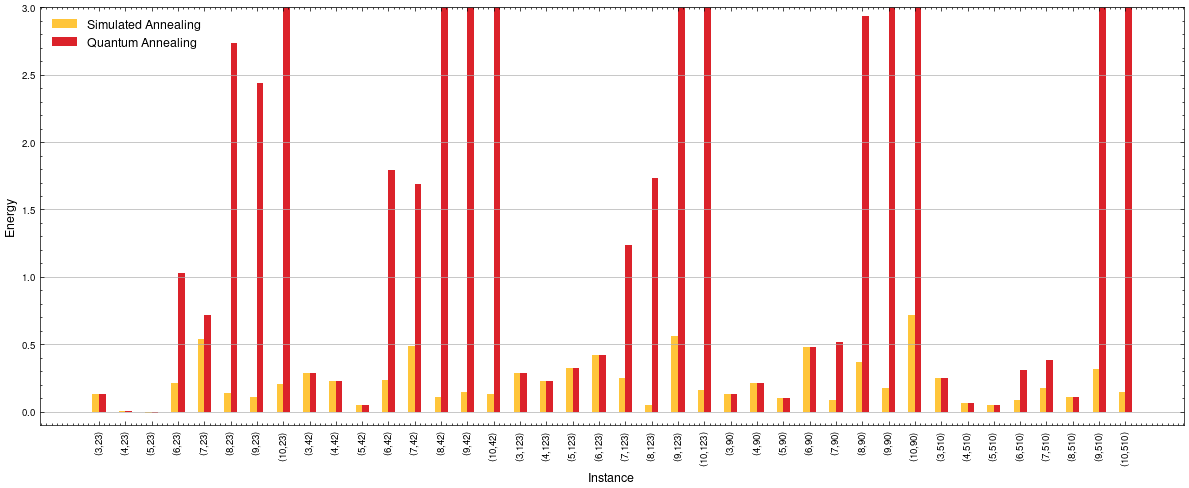

In [28]:
plot_eigenval(df_eigen)

## Feasibility density

What follows is a bar plot to visualize the probability of finding feasible solutions for different instance sizes.

In [29]:
df_feasible_density_SA = df_final_SA.groupby('instance_name', sort=False)['AL_SA_feasible'].apply(lambda x: (x==True).sum())/len(seeds)
df_feasible_density_QA = df_final_QA.groupby('instance_name', sort=False)['AL_QA_feasible'].apply(lambda x: (x==True).sum())/len(seeds)
df_feasible_density = pd.concat([df_feasible_density_SA, df_feasible_density_QA], axis=1)
df_feasible_density.head()

,AL_SA_feasible,AL_QA_feasible
instance_name,,
bpp_3_10,1.0,1.0
bpp_4_10,1.0,1.0
bpp_5_10,1.0,1.0
bpp_6_10,1.0,0.6
bpp_7_10,1.0,0.4


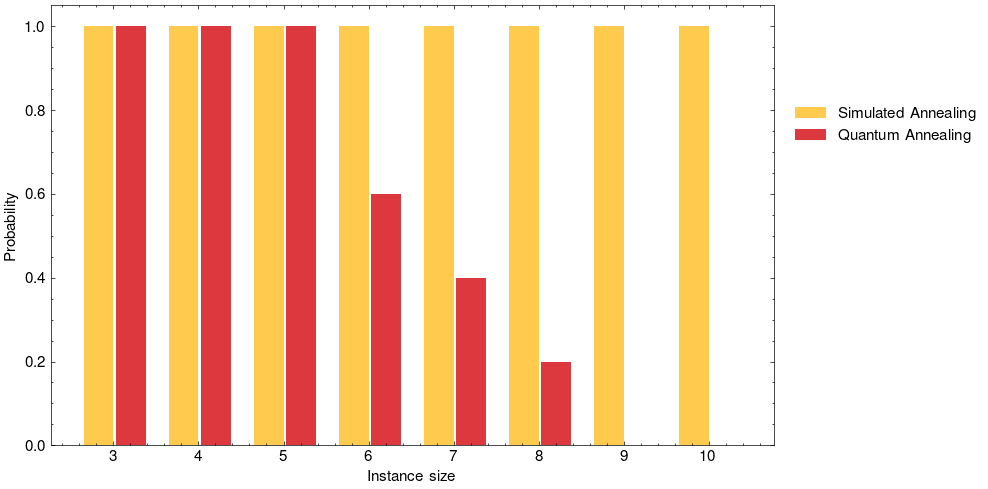

In [30]:
plot_feasibility_density(df_feasible_density)

## Runtime metrics

In [31]:
df_mean_std_runtime_metrics_QA = df_final_QA.groupby(['instance_name', 'n'], sort=False)[
       'AL_QA_runtime_metrics_qpu_sampling_time',
       'AL_QA_runtime_metrics_qpu_anneal_time_per_sample',
       'AL_QA_runtime_metrics_qpu_readout_time_per_sample',
       'AL_QA_runtime_metrics_qpu_access_time',
       'AL_QA_runtime_metrics_qpu_access_overhead_time',
       'AL_QA_runtime_metrics_qpu_programming_time',
       'AL_QA_runtime_metrics_qpu_delay_time_per_sample',
       'AL_QA_runtime_metrics_total_post_processing_time',
       'AL_QA_runtime_metrics_post_processing_overhead_time'].agg(['mean', 'std'])

df_mean_std_runtime_metrics_QA.columns = df_mean_std_runtime_metrics_QA.columns.map('_'.join)
df_mean_std_runtime_metrics_QA = df_mean_std_runtime_metrics_QA.reset_index()
display(df_mean_std_runtime_metrics_QA)

<ipython-input-31-9c5c8bf00763>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mean_std_runtime_metrics_QA = df_final_QA.groupby(['instance_name', 'n'], sort=False)[


,instance_name,n,AL_QA_runtime_metrics_qpu_sampling_time_mean,AL_QA_runtime_metrics_qpu_sampling_time_std,AL_QA_runtime_metrics_qpu_anneal_time_per_sample_mean,AL_QA_runtime_metrics_qpu_anneal_time_per_sample_std,AL_QA_runtime_metrics_qpu_readout_time_per_sample_mean,AL_QA_runtime_metrics_qpu_readout_time_per_sample_std,AL_QA_runtime_metrics_qpu_access_time_mean,AL_QA_runtime_metrics_qpu_access_time_std,AL_QA_runtime_metrics_qpu_access_overhead_time_mean,AL_QA_runtime_metrics_qpu_access_overhead_time_std,AL_QA_runtime_metrics_qpu_programming_time_mean,AL_QA_runtime_metrics_qpu_programming_time_std,AL_QA_runtime_metrics_qpu_delay_time_per_sample_mean,AL_QA_runtime_metrics_qpu_delay_time_per_sample_std,AL_QA_runtime_metrics_total_post_processing_time_mean,AL_QA_runtime_metrics_total_post_processing_time_std,AL_QA_runtime_metrics_post_processing_overhead_time_mean,AL_QA_runtime_metrics_post_processing_overhead_time_std
0,bpp_3_10,3,12148.4,1060.363523,20.0,0.0,80.944,10.603635,27907.17,1059.907656,1825.23,925.966436,15758.77,0.489898,20.54,0.0,176.6,42.618071,176.6,42.618071
1,bpp_4_10,4,11752.4,3284.803008,20.0,0.0,76.984,32.848030,27511.17,3284.880126,1755.23,536.219862,15758.77,0.489898,20.54,0.0,1449.8,1424.631952,1449.8,1424.631952
2,bpp_5_10,5,12681.6,1511.222948,20.0,0.0,86.276,15.112229,28441.17,1511.421291,1421.43,506.122337,15759.57,0.565685,20.54,0.0,1082.2,821.627470,1082.2,821.627470
3,bpp_6_10,6,15282.8,4642.613617,20.0,0.0,112.288,46.426136,31041.33,4642.252614,1812.87,985.295899,15758.53,0.669328,20.54,0.0,1633.0,1445.813093,1633.0,1445.813093
4,bpp_7_10,7,17459.6,3846.006604,20.0,0.0,134.056,38.460066,33219.49,3845.936114,1688.51,683.546628,15759.89,0.521536,20.54,0.0,851.4,859.881562,851.4,859.881562
5,bpp_8_10,8,14588.0,4395.262905,20.0,0.0,105.340,43.952629,30348.45,4394.711143,1405.15,512.552194,15760.45,1.109955,20.54,0.0,741.4,724.203563,741.4,724.203563
6,bpp_9_10,9,17616.4,3349.742199,20.0,0.0,135.624,33.497422,33377.97,3348.947453,1128.03,387.097972,15761.57,1.200000,20.54,0.0,756.0,716.513084,756.0,716.513084
7,bpp_10_10,10,21682.0,1290.618456,20.0,0.0,176.280,12.906185,37443.17,1289.438048,1765.23,222.140451,15761.17,2.383275,20.54,0.0,1627.8,914.545352,1627.8,914.545352


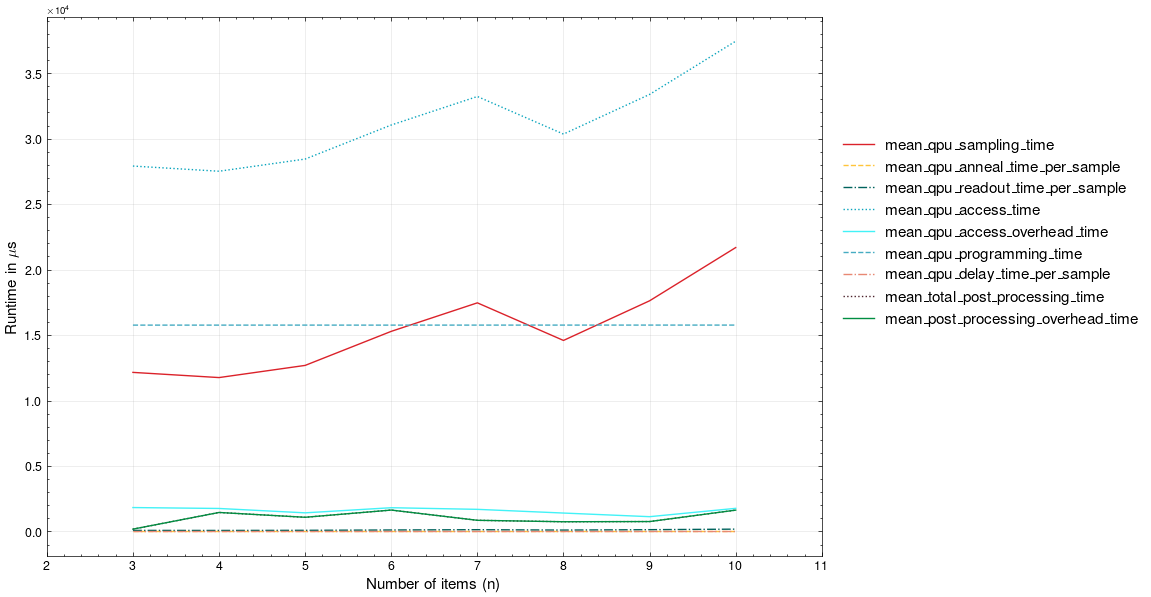

In [38]:
plot_all_runtime_metrics(df_mean_std_runtime_metrics_QA)

## Chain breaks analysis

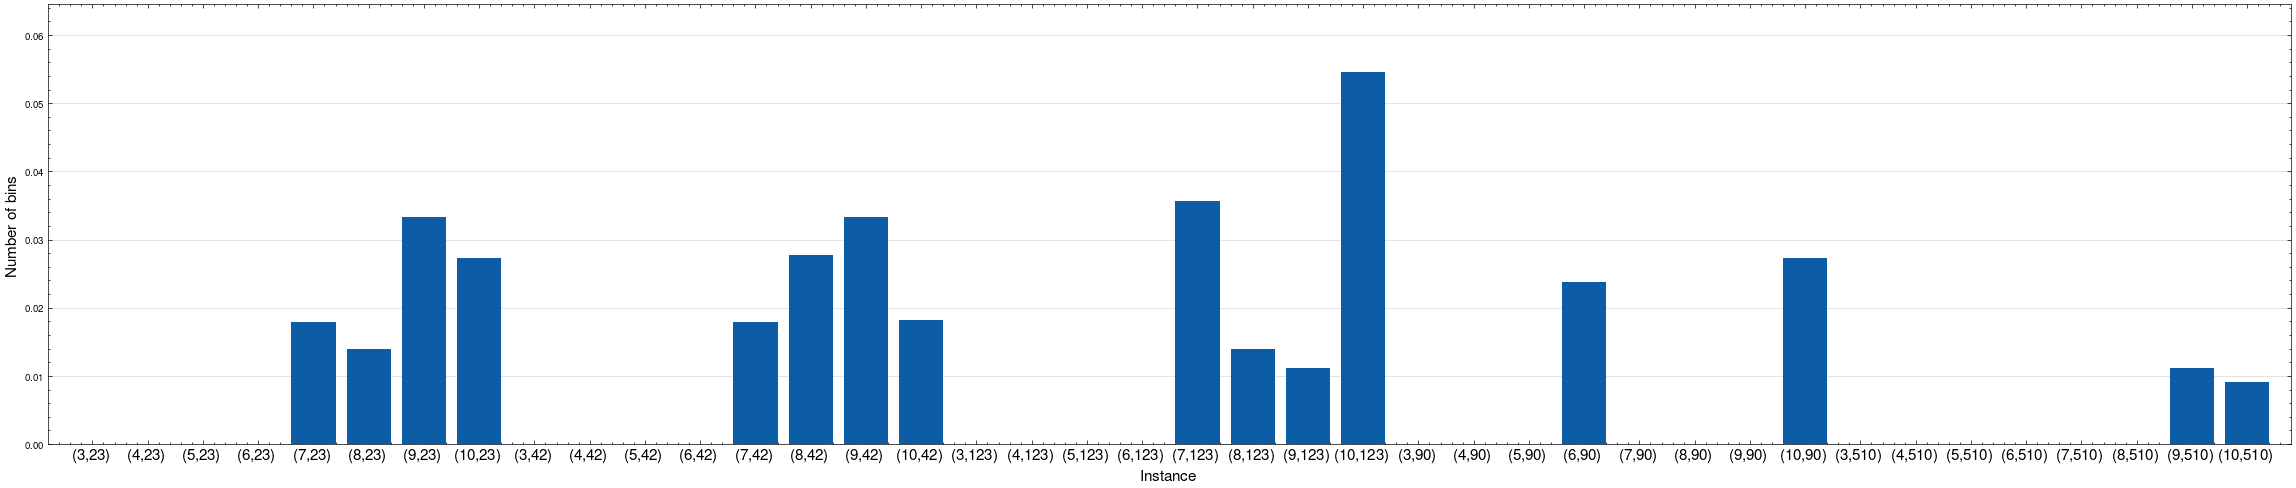

In [39]:
plot_chain_breaks(df_final_QA)

## Physical vs logical qubits

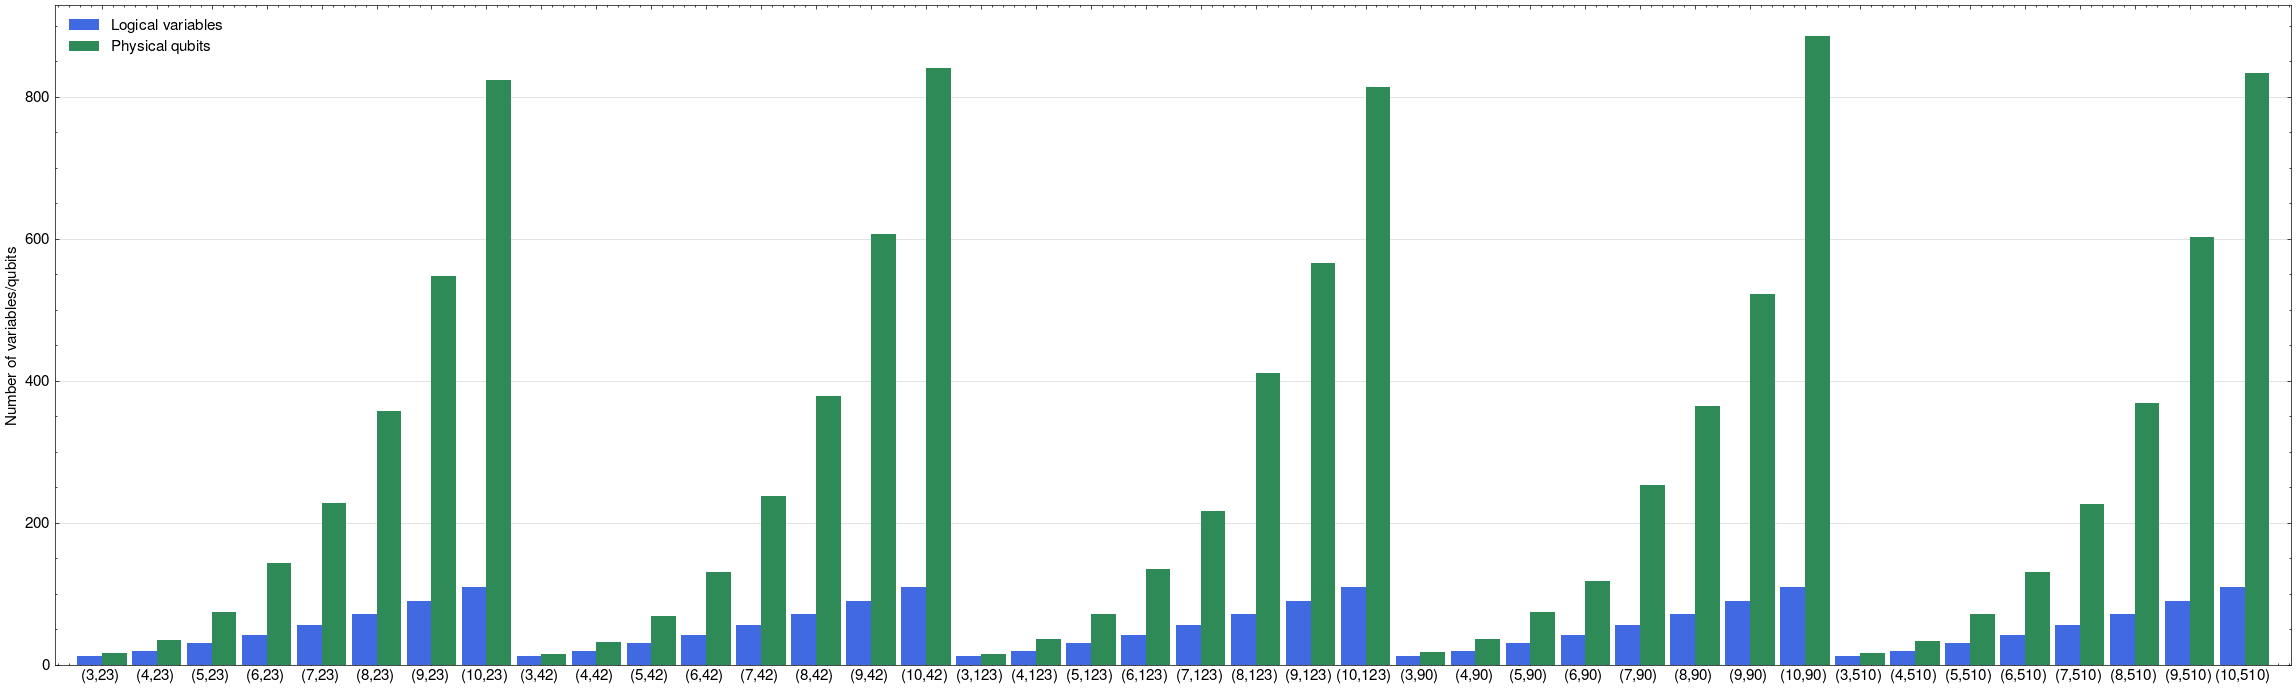

In [40]:
plot_phys_log_qubits(df_final_QA)